In [1]:
#%reset
import pandas as pd
%pylab inline
import seaborn as sns
sns.set(style="darkgrid")

Populating the interactive namespace from numpy and matplotlib


# Load data

In [2]:
customers_data_ini = pd.read_csv(
    'customers_data.csv', decimal=',', index_col=0)

# Delete 'order_purchase_timestamp' column
customers_data = customers_data_ini[
    [col for col in customers_data_ini.columns
     if col not in ['order_purchase_timestamp']]]

# Determine columns for clustering, cluster and intervals number

In [3]:
small_int_columns = []

value_columns = ['order_id', 'order_item_id', 'freight_value', 
                    'review_score', 'dist_to_seller', 'payment_value', 
                    'product_photos_qty', 'comment_propensity', 
                    'payment_installments']

# Define intervals number
intervals_n = 6
# Define clusters number
clusters_n = 7

# Functions

In [4]:
class MyNumber:
    def __init__(self, val):
        self.val = val

    def __format__(self, format_spec):
        ss = ('{0:'+format_spec+'}').format(self.val)
        if ('e' in ss):
            mantissa, exp = ss.split('e')
            return mantissa + 'e' + exp[2]
        return ss


def visu_columns_repartition(_cuts, _labels, _name):
    # Get table representing proportion of labels in each cut
    cross_tab_prop = pd.crosstab(
        index=_cuts, columns=_labels, normalize="index")
    # Get dispertion mean processing first dispertion for each label
    dispertion_mean = cross_tab_prop.apply(
        lambda x: np.std(x, ddof=1) / np.mean(x) * 100, axis=0).mean()
    # Float to string
    dispertion_mean_str = "{:.2f}".format(dispertion_mean)
    # Plot cross table representing proportion of labels in each cut
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
    cross_tab_prop.plot(kind='bar', stacked=True,
                        colormap='tab10', figsize=(16, 9), ax=ax)
    # Better display of intervals
    left = [float(re.findall(r"[-+]?(?:\d*\.\d+|\d+)", label.get_text())[0])
            for label in ax.get_xticklabels()]
    right = [float(re.findall(r"[-+]?(?:\d*\.\d+|\d+)", label.get_text())[1])
             for label in ax.get_xticklabels()]
    xlabels_n = ['[' + '{0:1.1e}'.format(MyNumber(i)) + ', ' + '{0:1.1e}'.format(
        MyNumber(j)) + ')' for i, j in zip(left, right)]
    ax.set_xticklabels(xlabels_n)
    # Get count table to have how many values for each cut
    cross_tab = pd.crosstab(index=_cuts, columns=_labels)
    # Display count table
    for n, x in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_loc) in zip(cross_tab_prop.loc[x],
                                              cross_tab.loc[x],
                                              cross_tab_prop.loc[x].cumsum()):

            plt.text(x=n - 0.17,
                     y=(y_loc - proportion) + (proportion / 2),
                     s=f'{count}\n({np.round(proportion * 100, 1)}%)',
                     color="black",
                     fontsize=12,
                     fontweight="bold")

    plt.title(_name+' dispertion: '+dispertion_mean_str, size=20)
    plt.legend(loc="upper left", ncol=2)
    plt.xlabel(_name+' dispertion', size=20)
    plt.ylabel("Proportion", size=20)
    plt.xticks(size=20)
    plt.show()


def visu_repartition(_customers_data, _labels):

    for column in _customers_data.columns:
        if column in small_int_columns:
            min_val = _customers_data[column].min()
            max_val = _customers_data[column].max()
            step = 1
            cuts_val = np.arange(min_val, max_val + step + 1, step)
            cuts = pd.cut(_customers_data[column], cuts_val, right=False)
        elif column in value_columns:
            intervals_temp = 0
            cpt = intervals_n
            while intervals_temp < intervals_n and cpt < 5e2:
                cuts = pd.qcut(_customers_data[column], cpt, duplicates='drop')
                intervals_temp = len(cuts.unique())
                cpt = cpt+1
        else:
            continue

        visu_columns_repartition(cuts, _labels, column)

In [5]:
def get_dispersion(_customers_data, _labels):

    dispersion = pd.DataFrame(columns=['dispersion'])
    for column in _customers_data.columns:
        if column in small_int_columns:
            min_val = _customers_data[column].min()
            max_val = _customers_data[column].max()
            step = 1
            cuts_val = np.arange(min_val, max_val + step + 1, step)
            cuts = pd.cut(_customers_data[column], cuts_val, right=False)
        elif column in value_columns:
            intervals_temp = 0
            cpt = intervals_n
            while intervals_temp < intervals_n and cpt < 5e2:
                cuts = pd.qcut(_customers_data[column], cpt, duplicates='drop')
                intervals_temp = len(cuts.unique())
                cpt = cpt+1
        else:
            continue

        cross_tab_prop = pd.crosstab(
            index=cuts, columns=_labels, normalize="index")

        dispersion.loc[column, 'dispersion'] = cross_tab_prop.apply(
            lambda x: np.std(x, ddof=1) / np.mean(x) * 100, axis=0).mean()

    return dispersion

In [6]:
def radarplot(_repartition_df):
    # Copy repartition dataframe
    repartition_df = _repartition_df.copy()
    
    # Get repartition dataframe index
    labels_ = repartition_df.index.to_list()
    # Copy first repartition element and put it at the end of repartition list
    labels_.append(labels_[0])

    # Copy repartition dataframe first row at the end of repartition of repartition dataframe
    repartition_df.loc[repartition_df.index[0]+'_'] = \
                       repartition_df.loc[repartition_df.index[0]]
    
    # Create axis from 0 to 2*PI
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(repartition_df))

    plt.figure(figsize=(12, 12))
    plt.subplot(polar=True)
    for method in repartition_df.columns:
        # Plot method repartition curve
        plt.plot(label_loc, repartition_df[method], label=method, linewidth=6)

    plt.title('Variables dispersion', size=20)
    # Transform linear plot to polar plot
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=labels_, size=15)
    plt.legend(fontsize=20)
    plt.yticks(size=15)
    plt.show()

# Clustering comparaison

In [7]:
import time

# Create dataframe to save score and dispersion for each clustering
scores_disp_df = pd.DataFrame(columns=['score', 'dispersion', 'cluster size std', 'execution time'])
repartition_df = pd.DataFrame(index=value_columns+small_int_columns)

In [8]:
from sklearn import preprocessing

# Create scaled dataframe
dataframe = customers_data[value_columns+small_int_columns]
dataframe_scaled = preprocessing.StandardScaler().fit_transform(dataframe)
dataframe_scaled = pd.DataFrame(
    dataframe_scaled, columns=dataframe.columns)

## Baseline Clustering with RFM

In [9]:
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Create Monetary column in customers dataframe
dataframe_m = customers_data
dataframe_m['Monetary'] = dataframe_m['price']*dataframe_m['order_id']
dataframe_scaled_m = preprocessing.StandardScaler().fit_transform(dataframe_m)
dataframe_scaled_m = pd.DataFrame(
    dataframe_scaled_m, columns=dataframe_m.columns)

# Create scaled recency/frequency/monetary dataframe
rfm_df = pd.DataFrame(index=customers_data.index)
rfm_df['Recency'] = dataframe_scaled_m['last_purchase_days']
rfm_df['Frequency'] = dataframe_scaled_m['order_id']
rfm_df['Monetary'] = dataframe_scaled_m['Monetary']

# Apply KMeans on scaled recency/frequency/monetary dataframe
start_time = time.time()
clusterer = KMeans(n_clusters=clusters_n).fit(rfm_df)
scores_disp_df.loc['rfm_baseline', 'execution time'] = time.time() - start_time

# Save silouette score and dispersion
scores_disp_df.loc['rfm_baseline', 'score'] = silhouette_score(
    dataframe_scaled, clusterer.labels_)
repartition_df.loc[:, 'rfm_baseline'] = get_dispersion(
    dataframe_scaled, clusterer.labels_).values
scores_disp_df.loc['rfm_baseline',
                   'dispersion'] = repartition_df['rfm_baseline'].mean()
scores_disp_df.loc['rfm_baseline', 'cluster size std'] = std(
    [sum(clusterer.labels_ == id) for id in set(clusterer.labels_)])

## KMeans

In [10]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Apply KMeans on scaled dataframe
start_time = time.time()
clusterer = KMeans(n_clusters=clusters_n, random_state=0).fit(dataframe_scaled)
scores_disp_df.loc['KMeans', 'execution time'] = time.time() - start_time

# Save silhouette score and dispersion
scores_disp_df.loc['KMeans', 'score'] = silhouette_score(
    dataframe_scaled, clusterer.labels_)
repartition_df.loc[:, 'KMeans'] = get_dispersion(
    dataframe_scaled, clusterer.labels_).values
scores_disp_df.loc['KMeans', 'dispersion'] = repartition_df['KMeans'].mean()
scores_disp_df.loc['KMeans', 'cluster size std'] = std(
    [sum(clusterer.labels_ == id) for id in set(clusterer.labels_)])

## Hierarchical/Agglomerative clustering

In [11]:
from sklearn.metrics import silhouette_score
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative clustering on scaled dataframe
start_time = time.time()
connectivity = kneighbors_graph(
    dataframe_scaled, n_neighbors=10, include_self=False)
clusterer = AgglomerativeClustering(
    n_clusters=clusters_n, connectivity=connectivity, linkage="ward")
clusterer.fit_predict(dataframe_scaled)
scores_disp_df.loc['Hierarchical', 'execution time'] = time.time() - start_time

# Save silhouette score and dispersion
scores_disp_df.loc['Hierarchical', 'score'] = silhouette_score(
    dataframe_scaled, clusterer.labels_)
repartition_df.loc[:, 'Hierarchical'] = get_dispersion(
    dataframe_scaled, clusterer.labels_).values
scores_disp_df.loc['Hierarchical',
                   'dispersion'] = repartition_df['Hierarchical'].mean()
scores_disp_df.loc['Hierarchical', 'cluster size std'] = std(
    [sum(clusterer.labels_ == id) for id in set(clusterer.labels_)])

## DBSCAN

In [12]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# Apply DBSCAN clustering on scaled dataframe
start_time = time.time()
clusterer = DBSCAN(eps=0.3, min_samples=10).fit(dataframe_scaled)
scores_disp_df.loc['DBSCAN', 'execution time'] = time.time() - start_time

# Save silhouette score and dispersion
scores_disp_df.loc['DBSCAN', 'score'] = silhouette_score(
    dataframe_scaled, clusterer.labels_)
repartition_df.loc[:, 'DBSCAN'] = get_dispersion(
    dataframe_scaled, clusterer.labels_).values
scores_disp_df.loc['DBSCAN',
                   'dispersion'] = repartition_df['DBSCAN'].mean()
scores_disp_df.loc['DBSCAN', 'cluster size std'] = std(
    [sum(clusterer.labels_ == id) for id in set(clusterer.labels_)])
dbscan_clusters_n = len(set(clusterer.labels_))
print('estimated labels number :', dbscan_clusters_n)

estimated labels number : 231


## BIRCH

In [13]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import Birch

# Apply Birch clustering on scaled dataframe
start_time = time.time()
clusterer = Birch(n_clusters=clusters_n).fit(dataframe_scaled)
scores_disp_df.loc['Birch', 'execution time'] = time.time() - start_time

# Save silhouette score and dispersion
scores_disp_df.loc['Birch', 'score'] = silhouette_score(
    dataframe_scaled, clusterer.labels_)
repartition_df.loc[:, 'Birch'] = get_dispersion(
    dataframe_scaled, clusterer.labels_).values
scores_disp_df.loc['Birch',
                   'dispersion'] = repartition_df['Birch'].mean()
scores_disp_df.loc['Birch', 'cluster size std'] = std(
    [sum(clusterer.labels_ == id) for id in set(clusterer.labels_)])

# Plot results

In [14]:
scores_disp_df.applymap("{0:.2f}".format)

,score,dispersion,cluster size std,execution time
rfm_baseline,0.01,71.71,14212.79,0.73
KMeans,0.27,84.05,13193.70,1.16
Hierarchical,0.23,86.19,15189.82,47.60
DBSCAN,-0.32,186.27,2967.56,36.13
Birch,0.29,93.85,26691.82,31.63


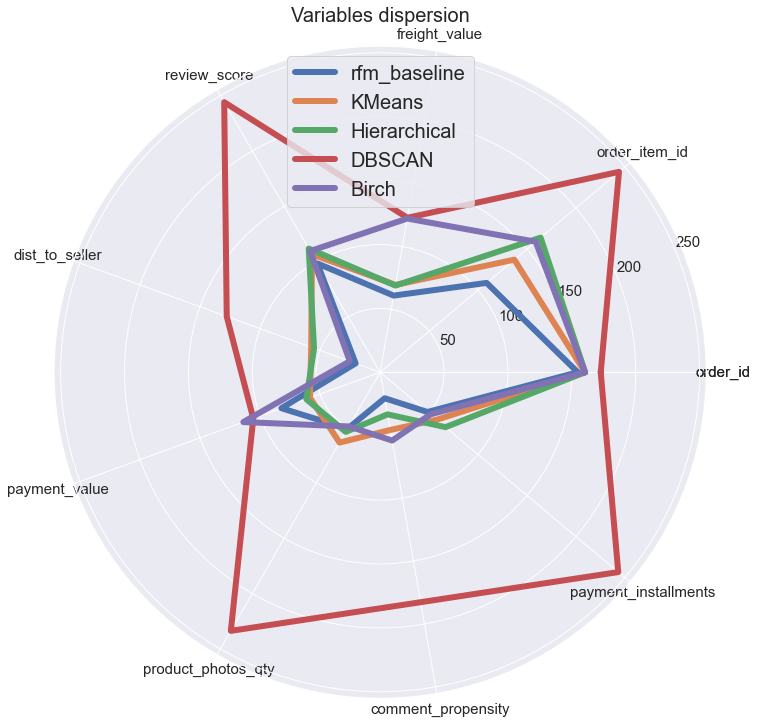

In [15]:
radarplot(repartition_df)

# Visualize clustering on Birch

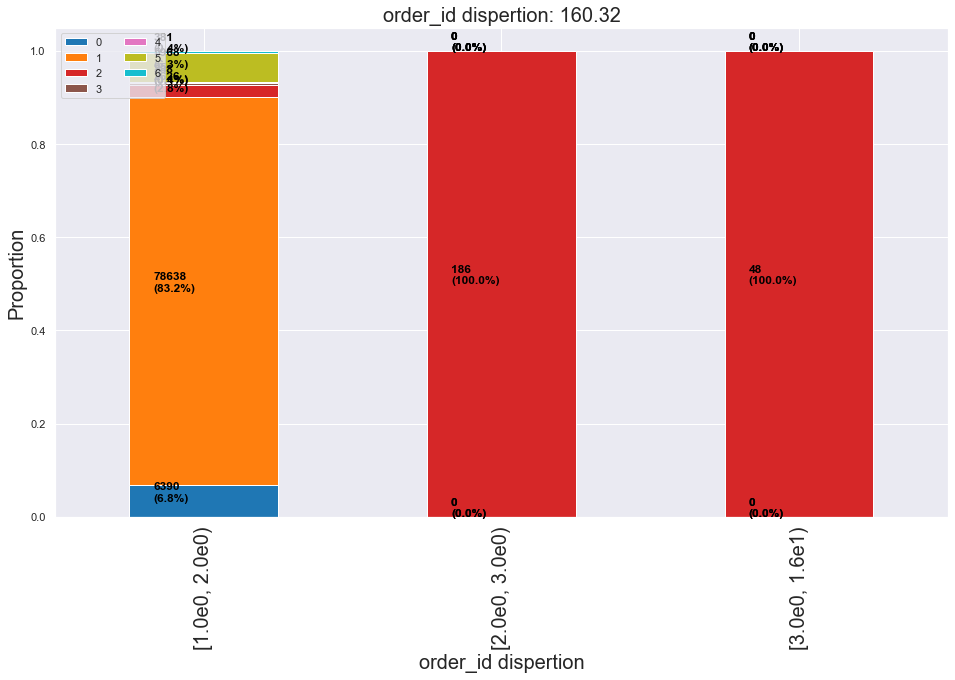

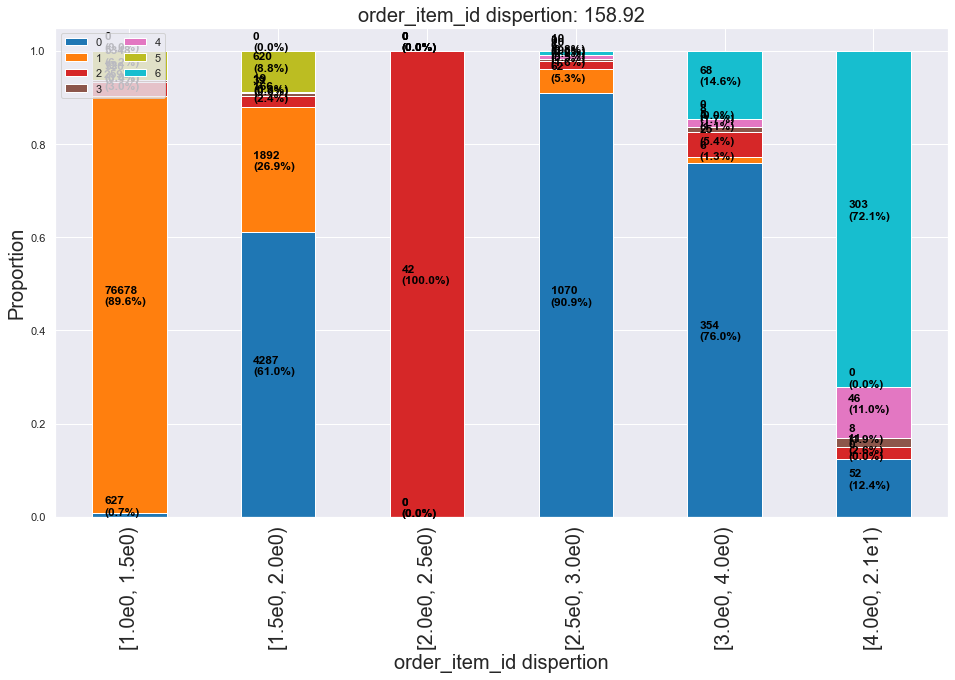

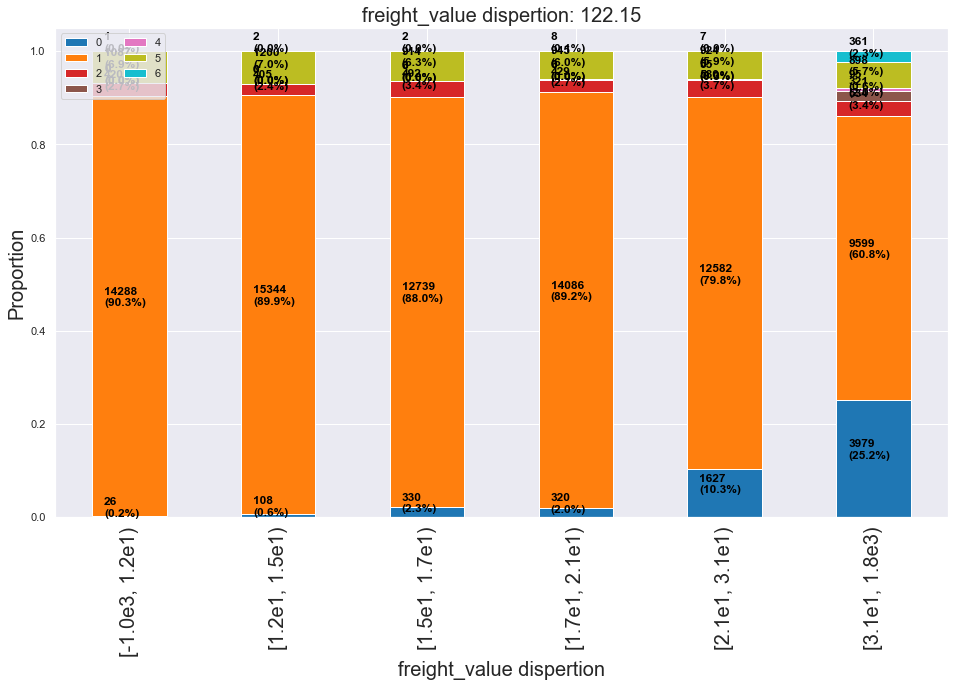

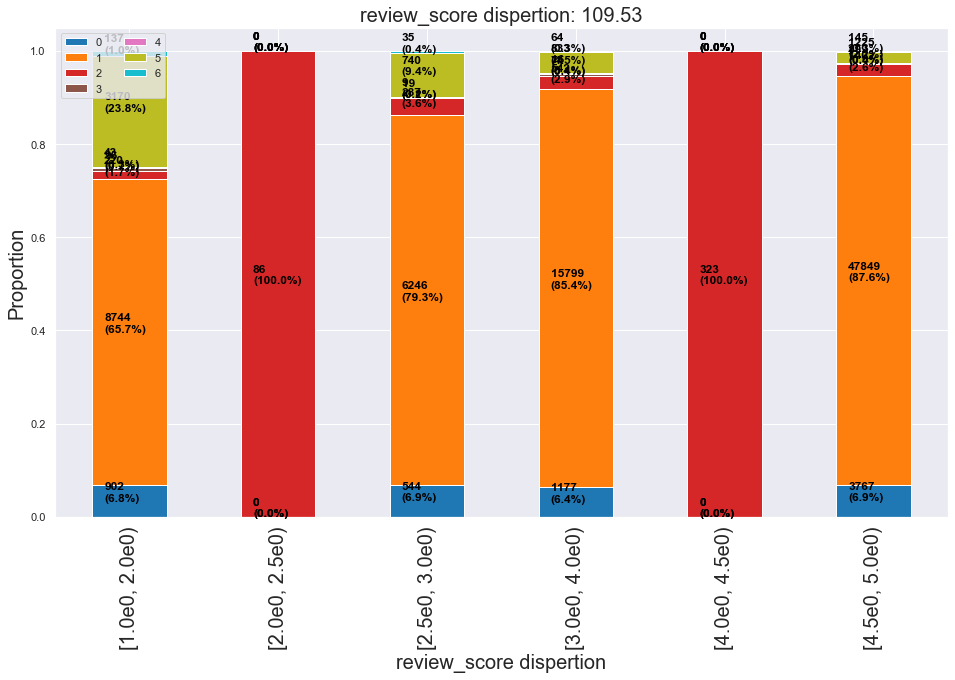

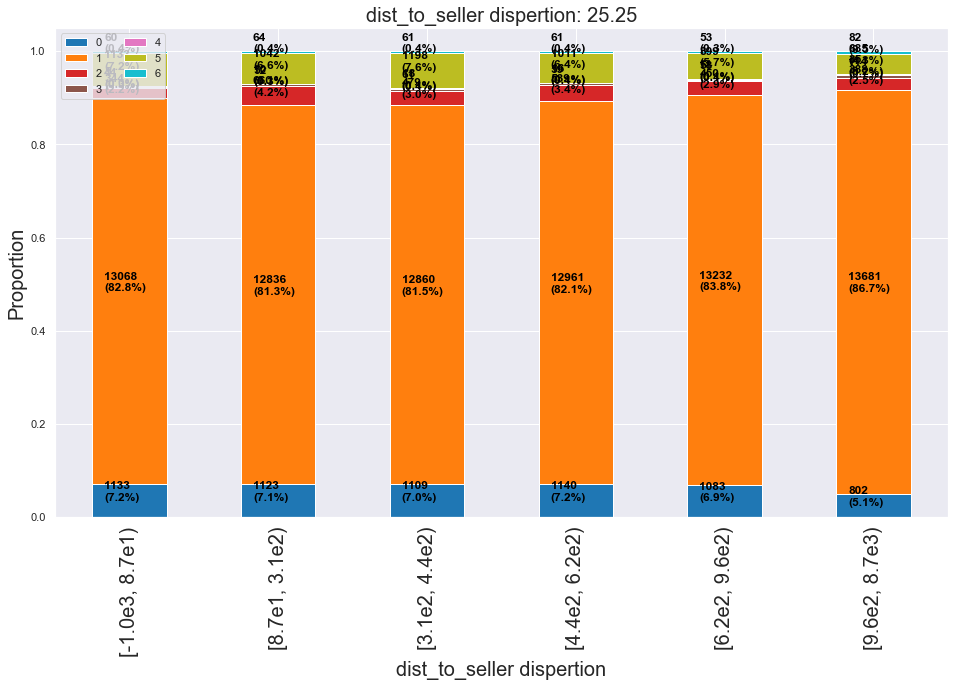

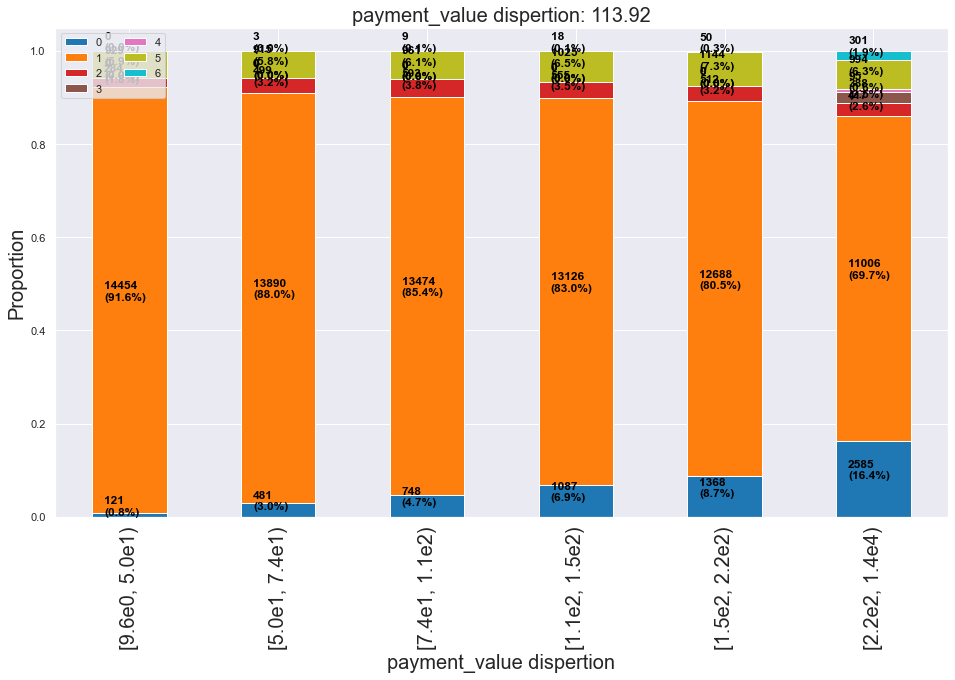

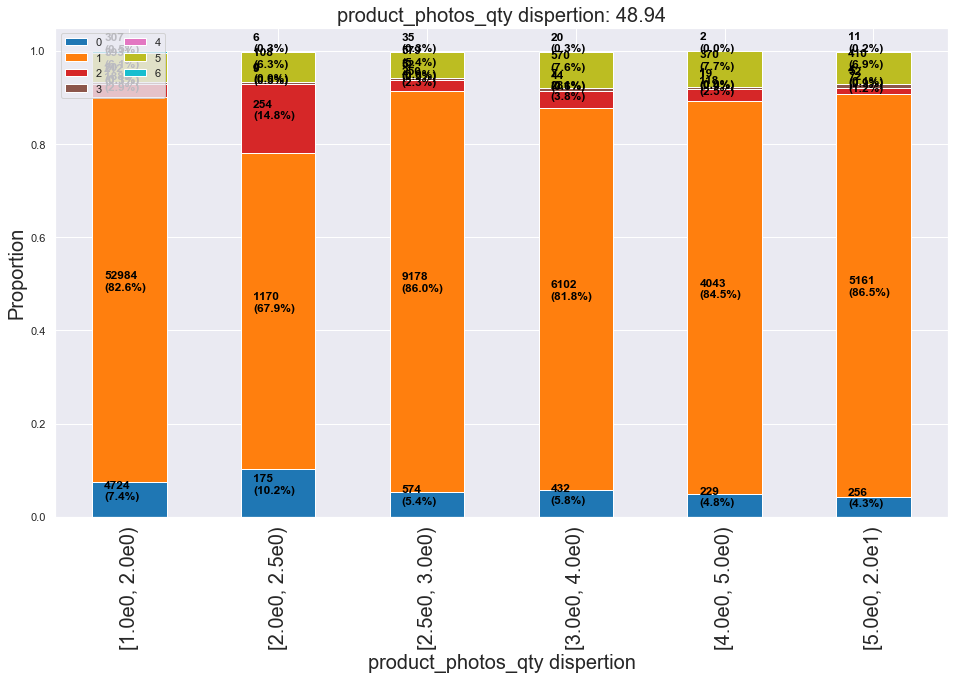

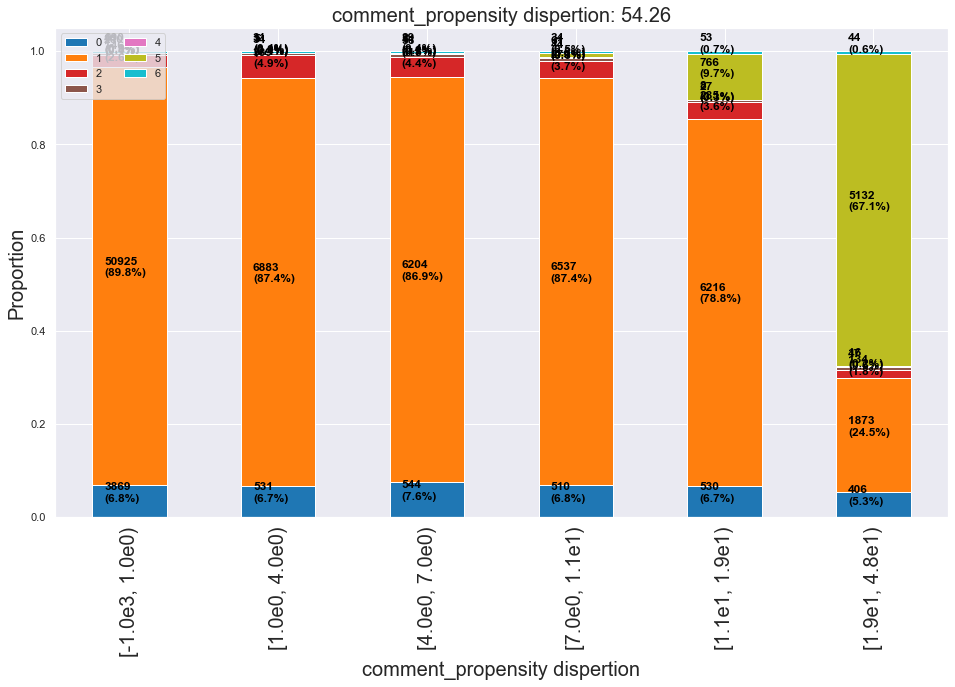

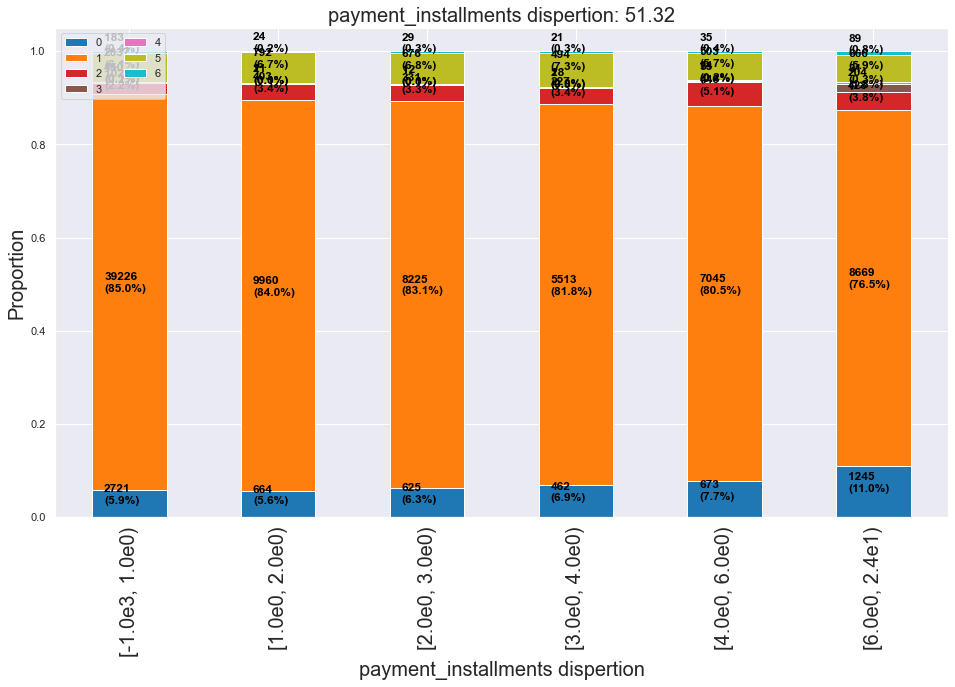

In [16]:
# Visualize repartition
visu_repartition(dataframe, clusterer.labels_)